Photon reconstruction study

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import griddata
from tqdm import tqdm

import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_ALL, ('de', 'utf-8'))

np.random.seed(0)

In [2]:
mv_to_spe = 0.1
time_range_in_ns = np.arange(0, 100, 0.5) # time in ns
pulse_pos_in_ns = 25
integration_window_len = 30 # slices
extraction_window_start = 35 # slice index
extraction_window_len = 90 # slices
time_extraction_window = time_range_in_ns[extraction_window_start:extraction_window_start+extraction_window_len]

In [3]:
def fact_pulse_in_mV(x, x0=0):
    p = (1.239*(1-1/(1+np.exp(((x-x0)-2.851)/1.063)))*np.exp(-((x-x0)-2.851)/19.173))
    p *= 10 # 1 spe (10mV)
    return p

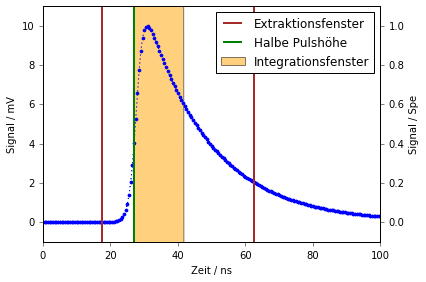

In [6]:
orginal_pulse = fact_pulse_in_mV(time_range_in_ns, pulse_pos_in_ns)
orginal_pulse_with_noise = orginal_pulse + np.random.normal(0, 1.5, size=len(orginal_pulse))

window_pulse = fact_pulse_in_mV(time_extraction_window, pulse_pos_in_ns)

maxPos = np.argmax(window_pulse)
maxHalf = window_pulse[maxPos] / 2.
half_pos = np.where(window_pulse[:maxPos+1] < maxHalf)[0]
if len(half_pos):
    half_pos = half_pos[-1]
else:
    half_pos = extraction_window_start
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_ylabel('Signal / Spe')
ax2.plot(time_range_in_ns, orginal_pulse*mv_to_spe, '.:', color='b')
ax2.set_ylim(-1*mv_to_spe, 11*mv_to_spe)

ax1.plot(time_range_in_ns, orginal_pulse, '.:', color='b')
ax1.set_ylabel('Signal / mV')
ax1.set_xlabel('Zeit / ns')
ax1.set_ylim(-1, 11)

plt.axvline(time_range_in_ns[extraction_window_start], color='brown', lw=2, label="Extraktionsfenster")
plt.axvline(time_range_in_ns[extraction_window_start+extraction_window_len], color='brown', lw=2)
plt.axvline(time_range_in_ns[extraction_window_start+half_pos], color='g', lw=2, label="Halbe Pulshöhe")

helper = np.zeros(len(time_range_in_ns))
helper[extraction_window_start+half_pos:extraction_window_start+half_pos+30] = 1

plt.fill_between(time_range_in_ns, -5, 5, where=helper == 1, facecolor='orange', alpha=0.5, interpolate=True, label='Integrationsfenster')
plt.xlim(0, 100)
plt.legend(loc="upper right")
# ax1.xaxis.set_minor_locator(MultipleLocator(10))
# ax1.yaxis.set_minor_locator(MultipleLocator(1))
# ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.tick_params(direction='out', top=False, which='both')
ax2.tick_params(direction='out', top=False, which='both')
fig.tight_layout()

plt.savefig('single_photon_pulse.png', dpi=200)

In [5]:
def basic_extraction(data):
    maxPos = np.argmax(data)
    maxHalf = data[maxPos] / 2.
    half_pos = np.where(data[:maxPos+1] < maxHalf)[0]
    if len(half_pos):
        half_pos = half_pos[-1]
    else:
        half_pos = extraction_window_start
    integral = data[half_pos:half_pos+30].sum()
    return {
        'arrivalTime': time_range_in_ns[extraction_window_start + half_pos],
        'integral': integral,
    }

In [6]:
gain = basic_extraction(window_pulse)['integral']
true_arrival_time = basic_extraction(window_pulse)['arrivalTime']

In [7]:
def basic_extraction_normalized(data):
    be = basic_extraction(data)
    be['integral'] /= gain
    be['arrivalTime'] -= true_arrival_time
    return be

In [8]:
df = pd.DataFrame(columns=['noise', 'offset', 'reconstruction_rate']) 
true_number_of_photons = 1
nr_runs = 1000
offset_range = np.arange(-2, 2, 0.5)
noise_range = np.linspace(1e-7, 4, len(offset_range))  #np.arange(1e-7, 3, 0.2)
for offset in tqdm(offset_range):
    for noise in noise_range:
        value_list = np.zeros(nr_runs)
        for i in range(nr_runs):
            y = true_number_of_photons * fact_pulse_in_mV(time_extraction_window, pulse_pos_in_ns)
            y += offset + np.random.normal(0, noise, size=len(y))
            d = basic_extraction_normalized(y)
#             if(float(d['integral']) > 1.5):
#                 print(d['integral'], d['integral'].round().astype(int), (d['integral'].round().astype(int) == true_number_of_photons))
            value_list[i] = (d['integral'].round().astype(int) == true_number_of_photons).astype(int)
            #print(d['integral'], d['integral'].round().astype(int), value_list[i])
        reconstruction_rate = np.round(value_list.sum()/nr_runs*100, 2)
        #print(value_list, sum(value_list))
        #print(noise, ": ", reconstruction_rate)
        df = df.append({'noise': noise,
                        'offset': offset,
                        'reconstruction_rate': reconstruction_rate}, 
                       ignore_index=True)
# with pd.HDFStore('1_photon_reconstruction_rate_test.h5') as store:
#     store['df'] = df

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


In [8]:
df = pd.DataFrame(columns=['noise', 'offset', 'reconstruction_rate']) 
nr_runs = 2000000
# pedestal results [mean, std]

drs_file =  np.array([[-0.00585571991849, 0.220521859428], # Interval 2
                      [-0.00375109082183, 0.201548650104], # Interval 3
                      [-0.00374080156656, 0.200934773846]])# Interval 3 after 2016-01-01
                     
version_0 = np.array([[-0.0171262524745, 0.22049917915],   # Interval 2
                      [0.00730133891913, 0.204817937786],  # Interval 3
                      [0.0182115850201, 0.201951906528]])  # Interval 3 after 2016-01-01

version_1 = np.array([[-0.0126335068067, 0.197767098783],  # Interval 3
                      [-0.00173001362963, 0.19451592982]]) # Interval 3 after 2016-01-01

#combi = np.append(drs_file, np.append(version_0, version_1, axis=0), axis=0)
combi = np.append(version_0, version_1, axis=0)
combi /= mv_to_spe
for offset, noise in combi:
    for true_number_of_photons in [1, 2, 3]:
        value_list = np.zeros(nr_runs)
        for i in range(nr_runs):
            y = true_number_of_photons * fact_pulse_in_mV(time_extraction_window, pulse_pos_in_ns)
            y += offset + np.random.normal(0, noise, size=len(y))
            d = basic_extraction_normalized(y)
            value_list[i] = (d['integral'].round().astype(int) == true_number_of_photons).astype(int)
        reconstruction_rate = np.round(value_list.sum()/nr_runs*100, 2)

        print('true_number_of_photons: ', true_number_of_photons,
              ', noise: ', noise,
              ', offset: ', offset,
              ', reconstruction_rate: ', reconstruction_rate)


true_number_of_photons:  1 , noise:  2.2049917915 , offset:  -0.171262524745 , reconstruction_rate:  99.58
true_number_of_photons:  2 , noise:  2.2049917915 , offset:  -0.171262524745 , reconstruction_rate:  99.96
true_number_of_photons:  3 , noise:  2.2049917915 , offset:  -0.171262524745 , reconstruction_rate:  100.0
true_number_of_photons:  1 , noise:  2.04817937786 , offset:  0.0730133891913 , reconstruction_rate:  99.84
true_number_of_photons:  2 , noise:  2.04817937786 , offset:  0.0730133891913 , reconstruction_rate:  99.99
true_number_of_photons:  3 , noise:  2.04817937786 , offset:  0.0730133891913 , reconstruction_rate:  100.0
true_number_of_photons:  1 , noise:  2.01951906528 , offset:  0.182115850201 , reconstruction_rate:  99.89
true_number_of_photons:  2 , noise:  2.01951906528 , offset:  0.182115850201 , reconstruction_rate:  99.99
true_number_of_photons:  3 , noise:  2.01951906528 , offset:  0.182115850201 , reconstruction_rate:  100.0
true_number_of_photons:  1 , noise

In [ ]:
df = pd.DataFrame(columns=['noise', 'offset', 'reconstruction_rate']) 
nr_runs = 2000000
# pedestal results [mean, std]

drs_file =  np.array([[-0.00585571991849, 0.220521859428], # Interval 2
                      [-0.00375109082183, 0.201548650104], # Interval 3
                      [-0.00374080156656, 0.200934773846]])# Interval 3 after 2016-01-01
                     
version_0 = np.array([[-0.0171262524745, 0.22049917915],   # Interval 2
                      [0.00730133891913, 0.204817937786],  # Interval 3
                      [0.0182115850201, 0.201951906528]])  # Interval 3 after 2016-01-01

version_1 = np.array([[-0.0126335068067, 0.197767098783],  # Interval 3
                      [-0.00173001362963, 0.19451592982]]) # Interval 3 after 2016-01-01

combi = version_1
combi /= mv_to_spe
for offset, noise in combi:
    for true_number_of_photons in [1, 2, 3]:
        value_list = np.zeros(nr_runs)
        for i in range(nr_runs):
            y = true_number_of_photons * fact_pulse_in_mV(time_extraction_window, pulse_pos_in_ns)
            y += offset + np.random.normal(0, noise, size=len(y))
            d = basic_extraction_normalized(y)
            value_list[i] = (d['integral'].round().astype(int) == true_number_of_photons).astype(int)
        reconstruction_rate = np.round(value_list.sum()/nr_runs*100, 2)

        print('true_number_of_photons: ', true_number_of_photons,
              ', noise: ', noise,
              ', offset: ', offset,
              ', reconstruction_rate: ', reconstruction_rate)
